# VI User Clustering

## Table of Contents

1. [Loading the Data and Necessary Libraries](#loading-dependencies)
2. [Proximity Prestige & Degree Centrality ](#prestige)
3. [Comment Quality](#quality)
4. [Save Results](#save)


## Loading Data and Libraries 
<a class="anchor" id="loading-dependencies"></a>

In [31]:
import pandas as pd
import numpy as np
from dbscan import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from scipy.signal import normalize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.rc('font', family= 'Times New Roman', size= 14)

df = pd.read_parquet('user_Vectors.parquet')

## Aggregating Users over all Articles
<a class="anchor" id="loading-dependencies"></a>

In [3]:
result = df.groupby('userID').sum()
result = result[["proximity_prestige","comment_quality","degree_centrality"]].copy()
result.head()

,proximity_prestige,comment_quality,degree_centrality
userID,,,
0,0.000000,0.000132,0.000000
1045,0.000000,0.000007,0.000000
1072,0.055816,0.004904,0.037555
1159,0.005650,0.000255,0.005650
1166,0.041705,0.009325,0.041466


## DBSCAN Clustering
<a class="anchor" id="clustering"></a>

In [5]:
X = result.values
labels, core_samples_mask = DBSCAN(X, eps=0.50, min_samples=1)
result['DBSCAN_cluster'] = labels

unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:")
print(np.asarray((unique, counts)).T)

Cluster sizes:
[[     0      1]
 [     1      1]
 [     2      2]
 [     3      1]
 [     4      1]
 [     5      1]
 [     6      1]
 [     7      1]
 [     8      4]
 [     9      1]
 [    10      5]
 [    11      1]
 [    12      1]
 [    13      1]
 [    14      1]
 [    15      2]
 [    16      2]
 [    17      3]
 [    18      1]
 [    19      1]
 [    20      1]
 [    21      1]
 [    22      1]
 [    23     10]
 [    24      2]
 [    25     11]
 [    26      2]
 [    27      1]
 [    28      1]
 [    29      2]
 [    30 402774]
 [    31      2]
 [    32      2]
 [    33      1]
 [    34      1]
 [    35      1]
 [    36      3]
 [    37      1]
 [    38      1]
 [    39      1]
 [    40      1]
 [    41      1]
 [    42      1]
 [    43      1]
 [    44      2]
 [    45      8]
 [    46      1]
 [    47      2]
 [    48      1]
 [    49      1]
 [    50      1]
 [    51      1]
 [    52      1]
 [    53      1]
 [    54      1]
 [    55      1]
 [    56      2]
 [    57      1]

## Labeling outlyers  
<a class="anchor" id="labels"></a>

In [7]:
Normal_users_cluster = result.DBSCAN_cluster.value_counts().reset_index().iloc[0]["DBSCAN_cluster"]
result['category'] = np.where(result['DBSCAN_cluster'] != Normal_users_cluster, 'outlier', 'normal')
result.value_counts("category")

category
normal     402774
outlier       183
Name: count, dtype: int64

## Visualizing Users
<a class="anchor" id="visualize"></a>

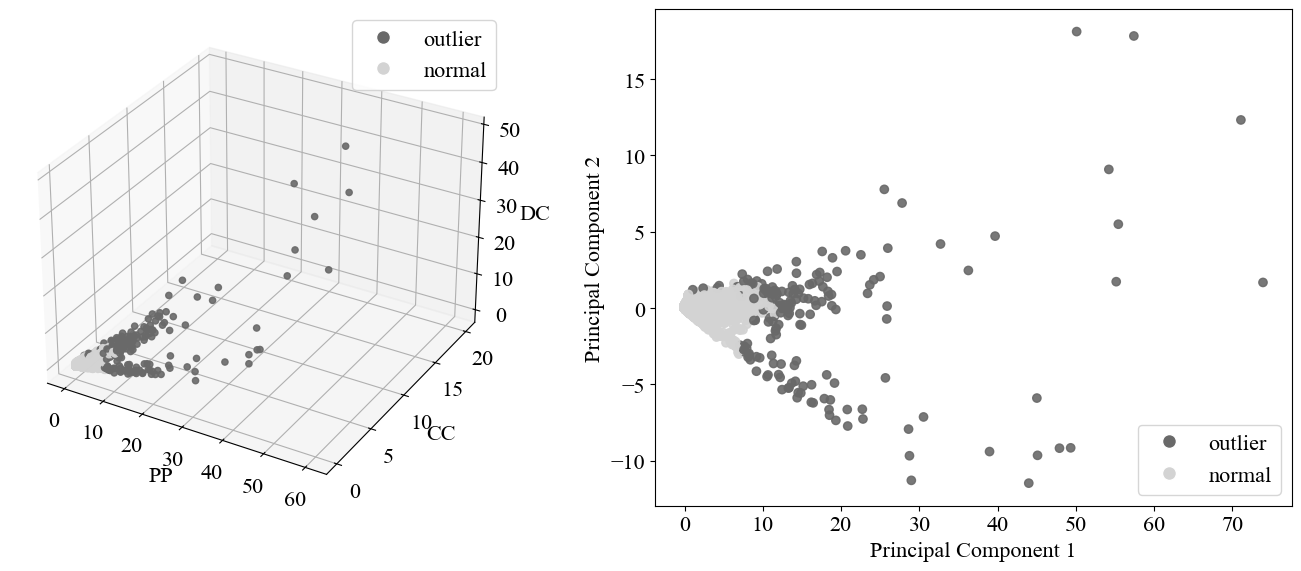

In [8]:
colors = np.where(result['category'] == 'outlier', 'dimgray', 'lightgray')

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, label=result['category'], alpha=0.9)
ax1.set_xlabel('PP')
ax1.set_ylabel('CC')
ax1.set_zlabel('DC')
scatter_legend_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgray', markersize=10, label='outlier'),
                     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label='normal')]
ax1.legend(handles=scatter_legend_3d)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

ax2 = fig.add_subplot(1, 2, 2)
scatter_2d = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.9)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
scatter_legend_2d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgray', markersize=10, label='outlier'),
                     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label='normal')]
ax2.legend(handles=scatter_legend_2d,loc = 'lower right')

plt.tight_layout()
plt.show()

## Outlyer Ranking
<a class="anchor" id="ranking"></a>

In [8]:
'''
Aggregation of the user vectors per article to a platform wide vector 
Injection of weights acording to the paper 
Calculation of the final user Vector
'''

pp_w = 10
cq_w = 0.3
dc_w = 10

result.loc[:, 'proximity_prestige'] *= pp_w
result.loc[:, 'comment_quality'] *= cq_w
result.loc[:, 'degree_centrality'] *= dc_w

result['S'] = (result['proximity_prestige'] + result['comment_quality'] + result['degree_centrality']) / 3
result = result.reset_index()
result.head()

,userID,proximity_prestige,comment_quality,degree_centrality,DBSCAN_cluster,category,S
0,0,0.000000,0.000040,0.000000,30,normal,1.322947e-05
1,1045,0.000000,0.000002,0.000000,30,normal,7.460631e-07
2,1072,0.558161,0.001471,0.375545,30,normal,3.117259e-01
3,1159,0.056497,0.000077,0.056497,30,normal,3.769033e-02
4,1166,0.417048,0.002797,0.414659,30,normal,2.781680e-01


## Visualizing Outlyers
<a class="anchor" id="visualize2"></a>

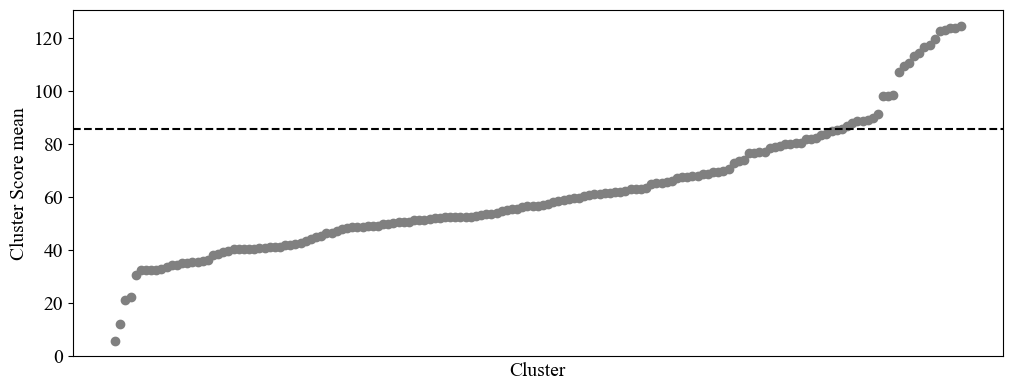

In [32]:
plt.figure(figsize=(12, 4.5)) 

test = result[result["category"]=="outlier"].sort_values("S").reset_index(drop=True)
plt.scatter(test.index,test["S"],color='gray')

mean_s = test['S'].mean()
std_s = test['S'].std()

plt.axhline(y=mean_s + std_s, color='black', linestyle='--')

plt.xlabel('Cluster')  
plt.ylabel('Cluster Score mean')  
plt.xticks([])
plt.show()

## Labeling Opinionleaders
<a class="anchor" id="visualize2"></a>

In [15]:
row_index = result[result.S > mean_s+std_s].index
result.loc[row_index, 'category'] = "OL"
result.value_counts("category")

category
normal     402774
outlier       165
OL             18
Name: count, dtype: int64

## Saving Results
<a class="anchor" id="save"></a>

In [18]:
result.to_parquet('cluster_results.parquet')

## Bonus Visual
<a class="anchor" id="visualize3"></a>

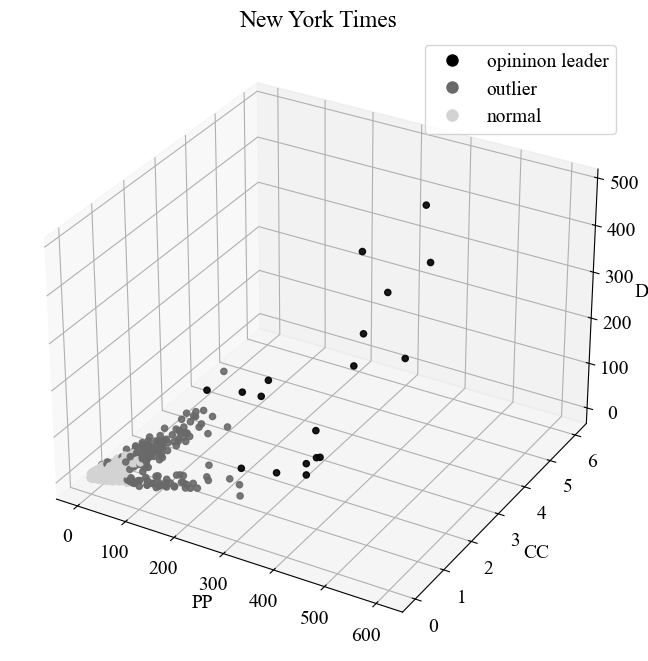

In [25]:
colors = np.where(result['category'] == 'outlier', 'dimgray', np.where(result['category'] == 'normal', 'lightgray', 'black'))

plot = plt.figure(figsize=(10, 8))
ax1 = plot.add_subplot(1,1,1, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, label=result['category'], alpha=0.9)
ax1.set_xlabel('PP')
ax1.set_ylabel('CC')
ax1.set_zlabel('DC')

scatter_legend_3d = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='opininon leader'),
                     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgray', markersize=10, label='outlier'),
                     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10, label='normal'),]
ax1.legend(handles=scatter_legend_3d)

plt.title("New York Times")
plt.show()
